In [1]:
import sys
sys.path.insert(0, '..')
sys.path.insert(0, '/Users/robinlinacre/Documents/data_linking/splink/')

In [2]:
from splink.duckdb.duckdb_linker import DuckDBLinker
import altair as alt
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

## Linking banking transactions

This example shows how to perform a one-to-one link on banking transactions.  The data has the following features:

- Money shows up in the destination account with some time delay
- The amount sent - which we can imagine is sometimes denominated in a foreign currency - and the amount received are not always the same
- The memo is sometimes truncated and content is sometimes missing

Since each origin payment should end up in the destination account, the `probability_two_random_records_match` of the model is known.

In [3]:
# Use arrow to read in data to ensure date types are correct
from pyarrow import parquet as pq
df_origin = pq.read_table("../data/transactions_left.parquet")
df_destination = pq.read_table("../data/transactions_right.parquet")
f"There are {df_origin.num_rows:,.0f} records to match"

'There are 45,326 records to match'

In [4]:
import duckdb 
con = duckdb.connect()
con.register("df", df_origin)

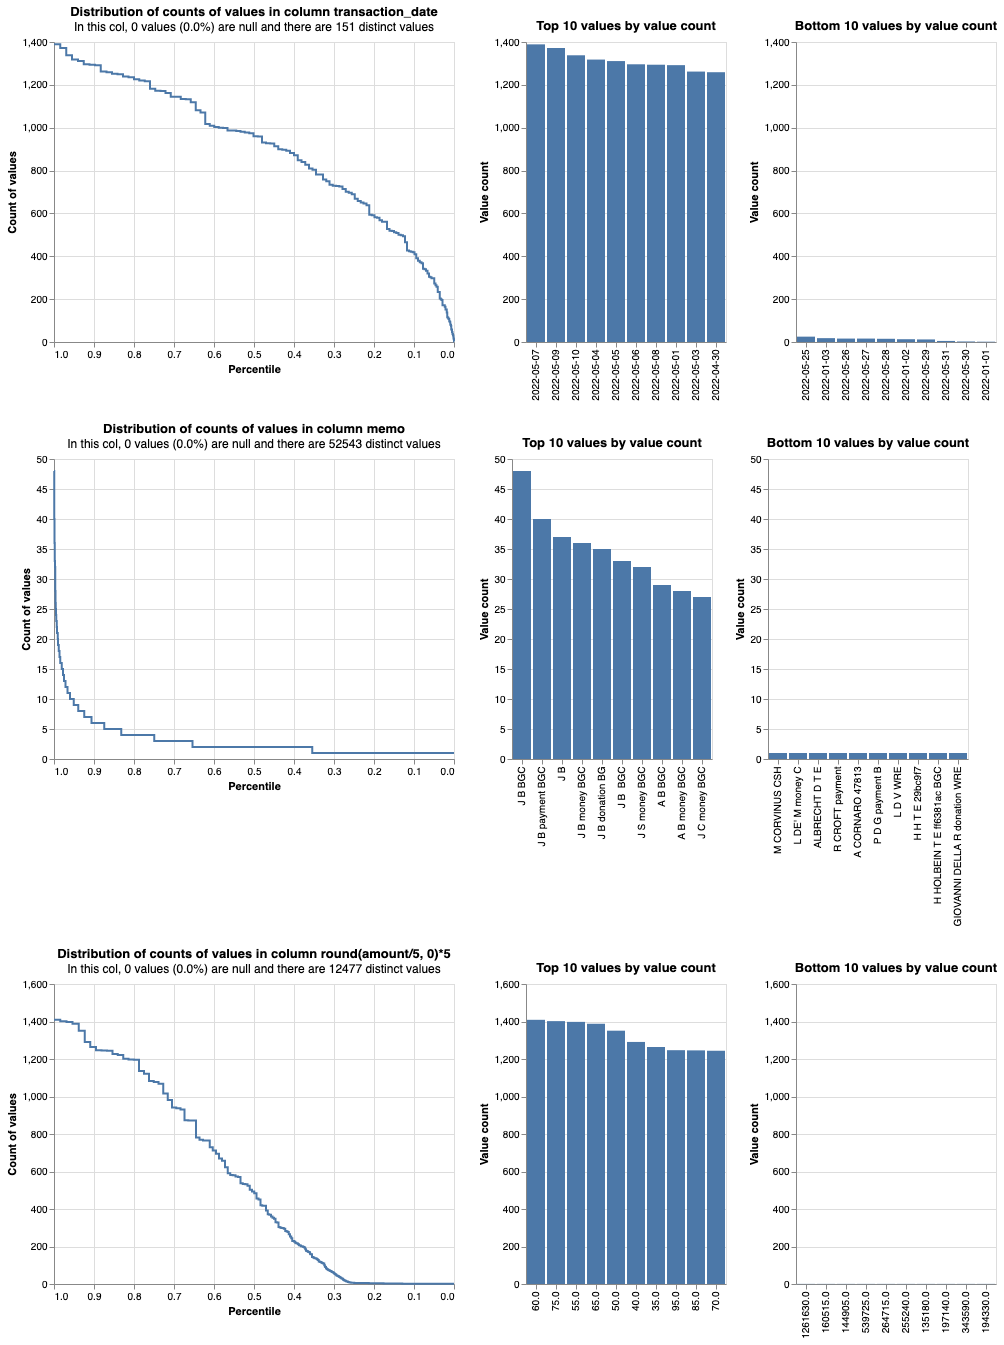

In [5]:
settings = {"link_type": "link_only"}
linker = DuckDBLinker([df_origin, df_destination], settings,input_table_aliases=["__ori", "_dest"])
linker.profile_columns(["transaction_date", "memo", "round(amount/5, 0)*5"])

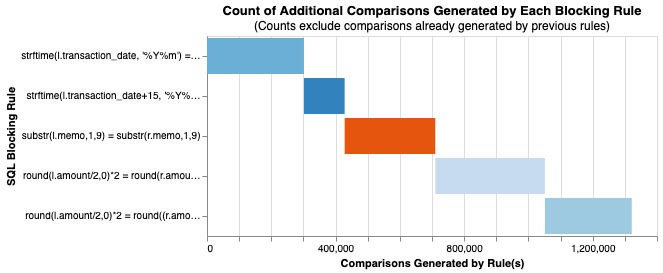

In [6]:
blocking_rule_date_1 = """
    strftime(l.transaction_date, '%Y%m') = strftime(r.transaction_date, '%Y%m')
    and substr(l.memo, 1,3) = substr(r.memo,1,3)
    and l.amount/r.amount > 0.7   and l.amount/r.amount < 1.3
"""

blocking_rule_date_2 = """
    strftime(l.transaction_date+15, '%Y%m') = strftime(r.transaction_date, '%Y%m')
    and substr(l.memo, 1,3) = substr(r.memo,1,3)
    and l.amount/r.amount > 0.7   and l.amount/r.amount < 1.3
"""

blocking_rule_memo = """
substr(l.memo,1,9) = substr(r.memo,1,9)
"""

blocking_rule_amount_1 = """
round(l.amount/2,0)*2 = round(r.amount/2,0)*2 and yearweek(r.transaction_date) = yearweek(l.transaction_date)
"""

blocking_rule_amount_2 = """
round(l.amount/2,0)*2 = round((r.amount+1)/2,0)*2 and yearweek(r.transaction_date) = yearweek(l.transaction_date + 4)
"""

linker.cumulative_num_comparisons_from_blocking_rules_chart(
    [blocking_rule_date_1, blocking_rule_date_2, blocking_rule_memo, blocking_rule_amount_1, blocking_rule_amount_2]
)

In [7]:
from splink.duckdb.duckdb_comparison_level_library import null_level

In [8]:
comparison_amount = {
    "output_column_name": "amount",
    "comparison_levels": [
        null_level("amount"),
        {"sql_condition": '"amount_l" = "amount_r"', "label_for_charts": "Exact match"},
        {"sql_condition": 'abs(amount_l-amount_r)/((amount_l+amount_r)/2) < 0.01', "label_for_charts": "< 1% diff"},
        {"sql_condition": 'abs(amount_l-amount_r)/((amount_l+amount_r)/2) < 0.03', "label_for_charts": "< 3% diff"},
        {"sql_condition": 'abs(amount_l-amount_r)/((amount_l+amount_r)/2) < 0.10', "label_for_charts": "< 10% diff"},
        {"sql_condition": 'abs(amount_l-amount_r)/((amount_l+amount_r)/2) < 0.30', "label_for_charts": "< 30% diff"},
        {"sql_condition": "ELSE", "label_for_charts": "All other comparisons"},
    ],
    "comparison_description": "Amount percentage difference",
}

comparison_date = {
    "output_column_name": "transaction_date",
    "comparison_levels": [
        null_level("transaction_date"),
        {"sql_condition": 'transaction_date_r - transaction_date_l <= 1 and transaction_date_r >= transaction_date_l', "label_for_charts": "1 day"},
        {"sql_condition": 'transaction_date_r - transaction_date_l <= 4 and transaction_date_r >= transaction_date_l', "label_for_charts": "<=4 days"},
        {"sql_condition": 'transaction_date_r - transaction_date_l <= 10 and transaction_date_r >= transaction_date_l', "label_for_charts": "<=10 days"},
        {"sql_condition": 'transaction_date_r - transaction_date_l <= 30 and transaction_date_r >= transaction_date_l', "label_for_charts": "<=30 days"},
        {"sql_condition": "ELSE", "label_for_charts": "All other comparisons"},
    ],
    "comparison_description": "Transaction date days apart",
}

from splink.duckdb import duckdb_comparison_library as cl

settings = {
    "link_type": "link_only",
    "probability_two_random_records_match": 1 / len(df_origin),
    "blocking_rules_to_generate_predictions": [
        blocking_rule_date_1,
        blocking_rule_date_2,
        blocking_rule_memo,
        blocking_rule_amount_1,
        blocking_rule_amount_2
    ],
    "comparisons": [
        comparison_amount,
        cl.jaccard_at_thresholds(
            "memo", [0.9, 0.8, 0.5]
        ),
        comparison_date
    ],
    "retain_intermediate_calculation_columns": True,
    "retain_matching_columns": True,
}

In [9]:
linker = DuckDBLinker([df_origin, df_destination], settings,input_table_aliases=["__ori", "_dest"])

In [10]:
linker.estimate_u_using_random_sampling(target_rows=1e7)

----- Estimating u probabilities using random sampling -----

Estimated u probabilities using random sampling

Your model is not yet fully trained. Missing estimates for:
    - amount (no m values are trained).
    - memo (no m values are trained).
    - transaction_date (no m values are trained).


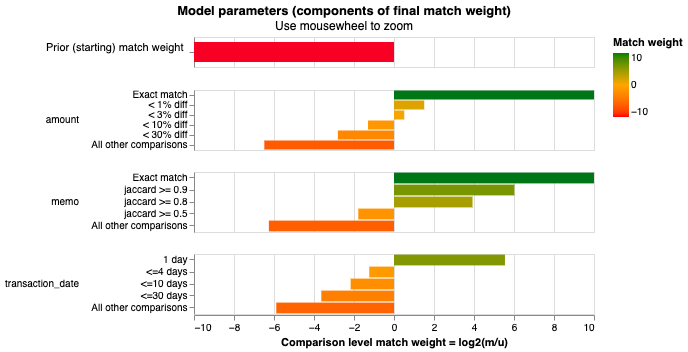

In [11]:
linker.match_weights_chart()

In [12]:
linker.estimate_parameters_using_expectation_maximisation("l.memo = r.memo")


----- Starting EM training session -----

Estimating the m probabilities of the model by blocking on:
l.memo = r.memo

Parameter estimates will be made for the following comparison(s):
    - amount
    - transaction_date

Parameter estimates cannot be made for the following comparison(s) since they are used in the blocking rules: 
    - memo

Iteration 1: Largest change in params was -0.436 in the m_probability of amount, level `Exact match`
Iteration 2: Largest change in params was -0.254 in the m_probability of transaction_date, level `1 day`
Iteration 3: Largest change in params was 0.02 in the m_probability of amount, level `< 10% diff`
Iteration 4: Largest change in params was 0.00352 in the m_probability of transaction_date, level `<=30 days`
Iteration 5: Largest change in params was 0.000597 in the m_probability of transaction_date, level `<=30 days`
Iteration 6: Largest change in params was 9.29e-05 in the m_probability of transaction_date, level `<=30 days`

EM converged afte

<EMTrainingSession, blocking on l.memo = r.memo, deactivating comparisons memo>


----- Starting EM training session -----

Estimating the m probabilities of the model by blocking on:
l.amount = r.amount

Parameter estimates will be made for the following comparison(s):
    - memo
    - transaction_date

Parameter estimates cannot be made for the following comparison(s) since they are used in the blocking rules: 
    - amount

Iteration 1: Largest change in params was -0.239 in the m_probability of memo, level `Exact match`
Iteration 2: Largest change in params was 0.193 in the m_probability of memo, level `jaccard >= 0.5`
Iteration 3: Largest change in params was 0.0676 in the m_probability of memo, level `jaccard >= 0.5`
Iteration 4: Largest change in params was 0.00634 in the m_probability of memo, level `jaccard >= 0.5`
Iteration 5: Largest change in params was 0.003 in the m_probability of memo, level `All other comparisons`
Iteration 6: Largest change in params was 0.00488 in the m_probability of memo, level `All other comparisons`
Iteration 7: Largest change

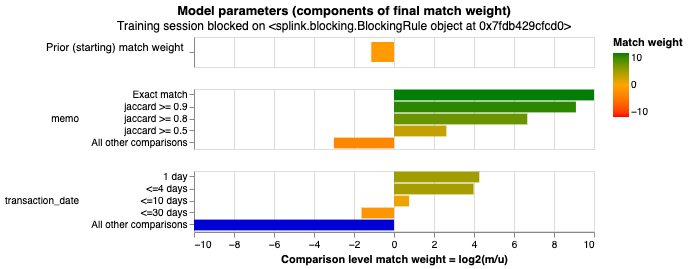

In [13]:
session = linker.estimate_parameters_using_expectation_maximisation("l.amount = r.amount")
session.match_weights_interactive_history_chart()

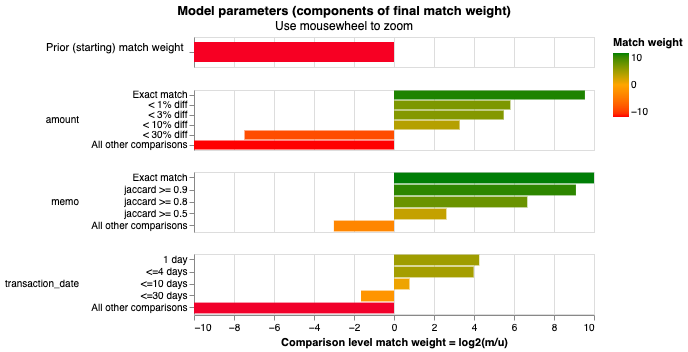

In [14]:
linker.match_weights_chart()

In [15]:
df_predict = linker.predict(threshold_match_probability=0.7)

In [16]:
df_predict.as_pandas_dataframe(limit=10)

,match_weight,match_probability,source_dataset_l,unique_id_l,source_dataset_r,unique_id_r,amount_l,amount_r,gamma_amount,bf_amount,memo_l,memo_r,gamma_memo,bf_memo,transaction_date_l,transaction_date_r,gamma_transaction_date,bf_transaction_date,match_key
0,4.624849,0.961048,__ori,140,_dest,140,11646.21,11735.62,4,56.432864,AIKATERINI C do,AIKATERINI C do,4,1253.941246,2022-04-27,2022-04-29,3,15.803268,0
1,4.569696,0.959592,__ori,172,_dest,172,115.68,112.68,3,44.771274,LEONARDO D VINC,LEONARDO D VINC,4,1253.941246,2022-01-28,2022-01-29,4,19.172412,0
2,4.903658,0.967672,__ori,220,_dest,220,207.25,207.15,4,56.432864,Z F payment BGC,Z F payment BGC,4,1253.941246,2022-05-09,2022-05-10,4,19.172412,0
3,3.707877,0.928913,__ori,226,_dest,226,46500.32,46877.96,4,56.432864,Z FERRERI BGC,Z FERRERI BGC,3,547.408026,2022-03-18,2022-03-19,4,19.172412,0
4,8.631103,0.997484,__ori,273,_dest,273,36.29,36.29,5,747.489139,EUCHARIUS RÖSSL,EUCHARIUS RÖSSL,4,1253.941246,2022-04-23,2022-04-24,4,19.172412,0
5,4.569696,0.959592,__ori,367,_dest,367,37760.70,37043.72,3,44.771274,W ZIEGLER d4b80,W ZIEGLER d4b80,4,1253.941246,2022-03-20,2022-03-21,4,19.172412,0
6,2.721049,0.868309,__ori,397,_dest,397,436.87,436.87,5,747.489139,I LOSA BGC,I LOSA BGC,4,1253.941246,2022-03-08,2022-03-20,1,0.318840,0
7,1.415413,0.727324,__ori,401,_dest,401,172.36,173.48,4,56.432864,GAUDENZIO F pay,GAUDENZIO F pay,4,1253.941246,2022-02-09,2022-02-14,2,1.708481,0
8,4.724422,0.963551,__ori,416,_dest,416,497.30,497.30,5,747.489139,N R money WRE,N R money,2,101.432872,2022-02-16,2022-02-18,3,15.803268,0
9,1.415413,0.727324,__ori,511,_dest,511,173.29,174.28,4,56.432864,CLÉMENT JANEQUI,CLÉMENT JANEQUI,4,1253.941246,2022-02-16,2022-02-22,2,1.708481,0


In [17]:
sql = f"""
select count(*) as num_false_positives, max(match_probability) as max_prob_amongst_false_positives
from {df_predict.physical_name}
where unique_id_l != unique_id_r
"""
linker._con.execute(sql).df()

,num_false_positives,max_prob_amongst_false_positives
0,195,0.967672


In [18]:
sql = f"""
select count(*) as num_true_positives
from {df_predict.physical_name}
where unique_id_l == unique_id_r
"""
linker._con.execute(sql).df()

,num_true_positives
0,22467


In [19]:
f"There were {df_origin.num_rows:,.0f} records to match"

'There were 45,326 records to match'